In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [3]:
df = pd.read_hdf('freesolv_with_samples.h5')

In [4]:
from openforcefield.topology import Molecule

In [5]:
inds = list(df.index)


allowed_elements = {1, 6, 8}

cho_freesolv = []
for key in inds:
    offmol = df['offmol'][key]
    if set([a.atomic_number for a in offmol.atoms]).issubset(allowed_elements):
        cho_freesolv.append(key)
print(len(cho_freesolv))

300


In [6]:
np.random.seed(0)
inds = list(cho_freesolv)
np.random.shuffle(inds)
train_inds = inds[::2]
valid_inds = inds[1::2]
len(train_inds), len(valid_inds)

(150, 150)

In [7]:
from openmmtools.constants import kB
from simtk import unit
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

temperature = 300 * unit.kelvin
kT = kB * temperature

# conversion from espaloma energy unit to kT
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

Using backend: pytorch


1052.5821686494048

In [20]:
df['offmol']['mobley_1017962'].partial_charges

Quantity(value=array([-0.09266   , -0.07967   , -0.07829   , -0.07824   , -0.12671   ,
        0.63147002, -0.53658998, -0.44984001,  0.12808   ,  0.03392   ,
        0.03392   ,  0.03392   ,  0.04138   ,  0.04138   ,  0.03957   ,
        0.03957   ,  0.05656   ,  0.05656   ,  0.07839   ,  0.07839   ,
        0.04963   ,  0.04963   ,  0.04963   ]), unit=elementary charge)

In [8]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
df['distance_matrices'] = None

for key in df.index:
    xyz = (df['quick_xyz'][key] * unit.nanometer).value_in_unit(DISTANCE_UNIT)
    distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
    distance_matrices = torch.stack(distance_matrices)
    df['distance_matrices'][key] = distance_matrices

In [22]:
df.columns

Index(['SMILES',
       'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
       'experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)',
       'Mobley group calculated value (GAFF) (kcal/mol)',
       'calculated uncertainty (kcal/mol)',
       'experimental reference (original or paper this value was taken from)',
       'calculated reference', 'text notes.', 'offmol',
       'serialized_openmm_system', 'xyz', 'quick_xyz', 'distance_matrices'],
      dtype='object')

In [9]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [10]:
def compute_obc2_energies(
    distance_matrices,
    radii, scales, charges,
    alpha=0.8, beta=0.0, gamma=2.909125
):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges, 
            alpha, beta, gamma,
        )
    return E_s

In [25]:
offmol = df['offmol'][key]

In [11]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

# radii, scales
atom_dim = 2

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, atom_dim), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    graph_model = ValenceModel(node_representation, readouts)
    return graph_model


def predict_obc2_params(offmol, graph_model):
    """output of graph net's atom representation will initially be near zero, just offset by a constant"""
    params = graph_model.forward(offmol)
    radii = params.atoms[:,0] + 2.5
    scales = params.atoms[:,1] + 1
    return radii, scales

In [12]:
def one_sided_exp(w):
    delta_f = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [13]:
def predict_on_key(key: str, graph_model, batch_size: int = 25, verbose: bool = False) -> float:
    offmol = df['offmol'][key]
    
    radii, scales = predict_obc2_params(offmol, graph_model)
    
    distance_matrices = df['distance_matrices'][key]
    inds = np.random.randint(0, len(distance_matrices), size=batch_size)
    
    charges = torch.tensor(offmol.partial_charges / unit.elementary_charge)
    
    obc2_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    if verbose:
        print(obc2_energies)
    w = obc2_energies * to_kT
    pred_delta_f = one_sided_exp(w)
    
    return pred_delta_f

In [29]:
train_inds

['mobley_6632459',
 'mobley_1502181',
 'mobley_7676709',
 'mobley_7393673',
 'mobley_2197088',
 'mobley_9565165',
 'mobley_5747981',
 'mobley_172879',
 'mobley_8754702',
 'mobley_7375018',
 'mobley_5890803',
 'mobley_3715043',
 'mobley_7017274',
 'mobley_6081058',
 'mobley_7497999',
 'mobley_3053621',
 'mobley_1261349',
 'mobley_7009711',
 'mobley_5467162',
 'mobley_9942801',
 'mobley_7039935',
 'mobley_2859600',
 'mobley_2261979',
 'mobley_7573149',
 'mobley_1244778',
 'mobley_2609604',
 'mobley_5390332',
 'mobley_2295058',
 'mobley_5157661',
 'mobley_9197172',
 'mobley_4035953',
 'mobley_2354112',
 'mobley_9246215',
 'mobley_8118832',
 'mobley_1717215',
 'mobley_4792268',
 'mobley_8809190',
 'mobley_4587267',
 'mobley_1967551',
 'mobley_5917842',
 'mobley_36119',
 'mobley_8573194',
 'mobley_7610437',
 'mobley_6854178',
 'mobley_820789',
 'mobley_9121449',
 'mobley_8785107',
 'mobley_4694328',
 'mobley_3234716',
 'mobley_5627459',
 'mobley_9112978',
 'mobley_3746675',
 'mobley_2577969

In [14]:
from tqdm import tqdm

In [15]:
import matplotlib.pyplot as plt

In [35]:
from openforcefield.topology import Molecule

In [126]:
torch.manual_seed(12345)
np.random.seed(12345)

In [127]:
graph_model = initialize()
learning_rate = 1e-3
optimizer = torch.optim.Adam(graph_model.parameters(), lr=learning_rate)

In [128]:
keys = train_inds
len(keys)

150

In [129]:
def get_all_preds(keys):
    """TODO: have this (and predict_on_key()) accept an argument that prevents subsampling the configurations"""
    predict_dict = dict()
    for key in keys:
        predict_dict[key] = float(predict_on_key(key, graph_model, 50).detach() * kT / unit.kilocalorie_per_mole)
    return predict_dict

In [130]:
def report_train_and_validation_rmse(predict_dict):
    train_residuals = np.array([predict_dict[key] - df['experimental value (kcal/mol)'][key] for key in train_inds])
    validation_residuals = np.array([predict_dict[key] - df['experimental value (kcal/mol)'][key] for key in valid_inds])
    
    return np.sqrt(np.mean(train_residuals**2)), np.sqrt(np.mean(validation_residuals**2))

In [131]:
predictions = []

batch_losses = []
trange = tqdm(range(1000))

n_mols_per_batch = 10
n_snapshots_per_mol = 15

for t in trange:
    
    # optionally subsample the training set...
    keys = np.random.choice(train_inds, size=n_mols_per_batch)
    
    L = 0.0
    for key in keys:
        # make a free energy prediction using a random subset of snapshots for each key
        prediction  = predict_on_key(key, graph_model, n_snapshots_per_mol)
        target = (df['experimental value (kcal/mol)'][key] * unit.kilocalorie_per_mole) / kT
    
        # TODO: modify loss function to depend on experimental error and simulation error
        L += (prediction - target)**2
        #predictions.append((t, key, prediction))
    
    L /= len(keys)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    rmse_in_kcalmol = np.sqrt(batch_losses[-1] * kT / unit.kilocalories_per_mole)
    trange.set_postfix(batch_rmse_in_kcalmol=rmse_in_kcalmol)
    
    n_batches_per_epoch = int(len(train_inds) / n_mols_per_batch)
    
    if t % n_batches_per_epoch == 0:
        epoch = int(t / n_batches_per_epoch)
        p = get_all_preds(cho_freesolv)
        predictions.append(p)
        train_rmse, valid_rmse = report_train_and_validation_rmse(p)
        print(f'training rmse: {train_rmse:.3f}')
        print(f'validation rmse: {valid_rmse:.3f}')
        
        torch.save(graph_model, f'cho_freesolv_epoch={epoch}.pt')

  0%|          | 1/1000 [00:20<5:34:09, 20.07s/it, batch_rmse_in_kcalmol=11.6]

training rmse: 8.845
validation rmse: 9.756


  2%|▏         | 16/1000 [00:44<1:35:07,  5.80s/it, batch_rmse_in_kcalmol=5.77]

training rmse: 4.565
validation rmse: 4.846


  3%|▎         | 31/1000 [01:07<1:28:33,  5.48s/it, batch_rmse_in_kcalmol=5.55]

training rmse: 3.730
validation rmse: 3.931


  5%|▍         | 46/1000 [01:30<1:27:18,  5.49s/it, batch_rmse_in_kcalmol=1.57]

training rmse: 3.011
validation rmse: 2.891


  6%|▌         | 61/1000 [01:53<1:24:58,  5.43s/it, batch_rmse_in_kcalmol=3.57]

training rmse: 2.470
validation rmse: 1.999


  8%|▊         | 76/1000 [02:16<1:24:00,  5.45s/it, batch_rmse_in_kcalmol=2.46]

training rmse: 2.106
validation rmse: 2.207


  9%|▉         | 91/1000 [02:39<1:22:20,  5.44s/it, batch_rmse_in_kcalmol=1.57]

training rmse: 1.763
validation rmse: 1.700


 11%|█         | 106/1000 [03:02<1:22:26,  5.53s/it, batch_rmse_in_kcalmol=0.969]

training rmse: 1.888
validation rmse: 2.076


 12%|█▏        | 121/1000 [03:26<1:25:18,  5.82s/it, batch_rmse_in_kcalmol=2.27] 

training rmse: 1.727
validation rmse: 1.406


 14%|█▎        | 136/1000 [03:50<1:21:33,  5.66s/it, batch_rmse_in_kcalmol=1.07]

training rmse: 1.528
validation rmse: 1.675


 15%|█▌        | 151/1000 [04:16<1:28:09,  6.23s/it, batch_rmse_in_kcalmol=0.975]

training rmse: 1.380
validation rmse: 1.231


 17%|█▋        | 166/1000 [04:40<1:19:28,  5.72s/it, batch_rmse_in_kcalmol=1.61] 

training rmse: 1.487
validation rmse: 1.638


 18%|█▊        | 181/1000 [05:04<1:19:47,  5.85s/it, batch_rmse_in_kcalmol=0.832]

training rmse: 1.194
validation rmse: 1.226


 20%|█▉        | 196/1000 [05:30<1:22:36,  6.16s/it, batch_rmse_in_kcalmol=0.987]

training rmse: 1.105
validation rmse: 1.183


 21%|██        | 211/1000 [05:57<1:21:44,  6.22s/it, batch_rmse_in_kcalmol=1.32] 

training rmse: 1.101
validation rmse: 1.134


 23%|██▎       | 226/1000 [06:22<1:18:53,  6.12s/it, batch_rmse_in_kcalmol=1.52]

training rmse: 1.067
validation rmse: 1.182


 24%|██▍       | 241/1000 [06:46<1:13:14,  5.79s/it, batch_rmse_in_kcalmol=0.84]

training rmse: 1.011
validation rmse: 1.143


 26%|██▌       | 256/1000 [07:12<1:16:36,  6.18s/it, batch_rmse_in_kcalmol=1.36]

training rmse: 1.000
validation rmse: 1.079


 27%|██▋       | 271/1000 [07:40<1:20:50,  6.65s/it, batch_rmse_in_kcalmol=1.2] 

training rmse: 1.023
validation rmse: 1.129


 29%|██▊       | 286/1000 [08:06<1:12:31,  6.09s/it, batch_rmse_in_kcalmol=1.51] 

training rmse: 1.261
validation rmse: 1.099


 30%|███       | 301/1000 [08:32<1:13:54,  6.34s/it, batch_rmse_in_kcalmol=1.45]

training rmse: 1.080
validation rmse: 1.189


 32%|███▏      | 316/1000 [08:59<1:11:40,  6.29s/it, batch_rmse_in_kcalmol=0.874]

training rmse: 1.019
validation rmse: 1.135


 33%|███▎      | 331/1000 [09:26<1:12:59,  6.55s/it, batch_rmse_in_kcalmol=1.79] 

training rmse: 0.942
validation rmse: 1.080


 35%|███▍      | 346/1000 [09:54<1:09:52,  6.41s/it, batch_rmse_in_kcalmol=2.15]

training rmse: 0.915
validation rmse: 1.085


 36%|███▌      | 361/1000 [10:21<1:10:43,  6.64s/it, batch_rmse_in_kcalmol=0.988]

training rmse: 1.168
validation rmse: 1.276


 38%|███▊      | 376/1000 [10:58<1:33:03,  8.95s/it, batch_rmse_in_kcalmol=1.37] 

training rmse: 1.320
validation rmse: 1.136


 39%|███▉      | 391/1000 [11:36<1:39:52,  9.84s/it, batch_rmse_in_kcalmol=2.27]

training rmse: 1.054
validation rmse: 1.175


 41%|████      | 406/1000 [12:24<1:47:29, 10.86s/it, batch_rmse_in_kcalmol=1.11] 

training rmse: 0.980
validation rmse: 1.123


 42%|████▏     | 421/1000 [12:59<1:16:02,  7.88s/it, batch_rmse_in_kcalmol=1.17]

training rmse: 0.931
validation rmse: 1.111


 44%|████▎     | 436/1000 [13:36<1:29:13,  9.49s/it, batch_rmse_in_kcalmol=0.733]

training rmse: 0.984
validation rmse: 1.020


 45%|████▌     | 451/1000 [14:19<1:33:08, 10.18s/it, batch_rmse_in_kcalmol=0.63] 

training rmse: 0.890
validation rmse: 1.032


 47%|████▋     | 466/1000 [14:59<1:25:25,  9.60s/it, batch_rmse_in_kcalmol=0.573]

training rmse: 0.892
validation rmse: 0.988


 48%|████▊     | 481/1000 [15:43<1:32:37, 10.71s/it, batch_rmse_in_kcalmol=1.4]  

training rmse: 0.923
validation rmse: 1.094


 50%|████▉     | 496/1000 [16:28<1:27:00, 10.36s/it, batch_rmse_in_kcalmol=1.09] 

training rmse: 0.963
validation rmse: 1.038


 51%|█████     | 511/1000 [17:10<1:21:20,  9.98s/it, batch_rmse_in_kcalmol=1.9]  

training rmse: 0.874
validation rmse: 1.051


 53%|█████▎    | 526/1000 [17:49<1:12:56,  9.23s/it, batch_rmse_in_kcalmol=1.23] 

training rmse: 0.857
validation rmse: 1.022


 54%|█████▍    | 541/1000 [18:28<1:11:37,  9.36s/it, batch_rmse_in_kcalmol=0.537]

training rmse: 0.887
validation rmse: 1.058


 56%|█████▌    | 556/1000 [19:06<1:06:45,  9.02s/it, batch_rmse_in_kcalmol=0.873]

training rmse: 0.839
validation rmse: 0.966


 57%|█████▋    | 571/1000 [19:55<1:29:09, 12.47s/it, batch_rmse_in_kcalmol=0.847]

training rmse: 0.866
validation rmse: 1.032


 59%|█████▊    | 586/1000 [20:38<1:11:31, 10.37s/it, batch_rmse_in_kcalmol=1.09] 

training rmse: 0.822
validation rmse: 0.970


 60%|██████    | 601/1000 [21:29<1:22:10, 12.36s/it, batch_rmse_in_kcalmol=2.08]

training rmse: 0.820
validation rmse: 0.957


 62%|██████▏   | 616/1000 [22:11<1:05:09, 10.18s/it, batch_rmse_in_kcalmol=0.538]

training rmse: 0.854
validation rmse: 0.912


 63%|██████▎   | 631/1000 [23:02<1:17:46, 12.65s/it, batch_rmse_in_kcalmol=0.659]

training rmse: 0.877
validation rmse: 0.903


 65%|██████▍   | 646/1000 [23:46<1:02:16, 10.56s/it, batch_rmse_in_kcalmol=1.24] 

training rmse: 0.897
validation rmse: 1.037


 66%|██████▌   | 661/1000 [24:31<1:01:51, 10.95s/it, batch_rmse_in_kcalmol=0.773]

training rmse: 1.033
validation rmse: 1.021


 68%|██████▊   | 676/1000 [25:24<1:08:34, 12.70s/it, batch_rmse_in_kcalmol=1.87] 

training rmse: 0.880
validation rmse: 0.997


 69%|██████▉   | 691/1000 [26:14<1:00:37, 11.77s/it, batch_rmse_in_kcalmol=1.74]

training rmse: 1.059
validation rmse: 1.216


 71%|███████   | 706/1000 [26:51<40:36,  8.29s/it, batch_rmse_in_kcalmol=1.68]  

training rmse: 0.946
validation rmse: 1.059


 72%|███████▏  | 721/1000 [27:19<31:02,  6.68s/it, batch_rmse_in_kcalmol=1.14] 

training rmse: 0.876
validation rmse: 1.025


 74%|███████▎  | 736/1000 [27:47<29:03,  6.60s/it, batch_rmse_in_kcalmol=0.672]

training rmse: 0.835
validation rmse: 0.969


 75%|███████▌  | 751/1000 [28:32<48:06, 11.59s/it, batch_rmse_in_kcalmol=1.05] 

training rmse: 0.786
validation rmse: 0.920


 77%|███████▋  | 766/1000 [29:08<31:12,  8.00s/it, batch_rmse_in_kcalmol=1.05] 

training rmse: 0.803
validation rmse: 0.925


 78%|███████▊  | 781/1000 [29:38<25:52,  7.09s/it, batch_rmse_in_kcalmol=0.781]

training rmse: 0.829
validation rmse: 0.934


 80%|███████▉  | 796/1000 [30:08<23:55,  7.04s/it, batch_rmse_in_kcalmol=1.8]  

training rmse: 0.806
validation rmse: 0.913


 81%|████████  | 811/1000 [30:36<21:29,  6.83s/it, batch_rmse_in_kcalmol=0.821]

training rmse: 0.775
validation rmse: 0.932


 83%|████████▎ | 826/1000 [31:04<19:19,  6.66s/it, batch_rmse_in_kcalmol=0.447]

training rmse: 0.902
validation rmse: 1.069


 84%|████████▍ | 841/1000 [31:47<29:41, 11.21s/it, batch_rmse_in_kcalmol=0.414]

training rmse: 0.905
validation rmse: 0.941


 86%|████████▌ | 856/1000 [32:32<25:30, 10.63s/it, batch_rmse_in_kcalmol=1.2]  

training rmse: 0.814
validation rmse: 0.980


 87%|████████▋ | 871/1000 [33:16<23:11, 10.79s/it, batch_rmse_in_kcalmol=1.11] 

training rmse: 0.787
validation rmse: 0.968


 89%|████████▊ | 886/1000 [34:00<20:25, 10.75s/it, batch_rmse_in_kcalmol=1.18] 

training rmse: 0.776
validation rmse: 0.924


 90%|█████████ | 901/1000 [34:27<10:26,  6.33s/it, batch_rmse_in_kcalmol=1.07] 

training rmse: 0.815
validation rmse: 0.929


 92%|█████████▏| 916/1000 [34:56<09:52,  7.06s/it, batch_rmse_in_kcalmol=1.57] 

training rmse: 0.771
validation rmse: 0.934


 93%|█████████▎| 931/1000 [35:24<07:52,  6.84s/it, batch_rmse_in_kcalmol=1.15] 

training rmse: 0.872
validation rmse: 1.053


 95%|█████████▍| 946/1000 [35:52<05:54,  6.56s/it, batch_rmse_in_kcalmol=1]    

training rmse: 0.733
validation rmse: 0.893


 96%|█████████▌| 961/1000 [36:17<03:54,  6.00s/it, batch_rmse_in_kcalmol=0.847]

training rmse: 0.852
validation rmse: 1.007


 98%|█████████▊| 976/1000 [36:42<02:23,  5.98s/it, batch_rmse_in_kcalmol=0.709]

training rmse: 0.798
validation rmse: 0.946


 99%|█████████▉| 991/1000 [37:10<01:00,  6.68s/it, batch_rmse_in_kcalmol=0.704]

training rmse: 0.740
validation rmse: 0.884


100%|██████████| 1000/1000 [37:15<00:00,  2.24s/it, batch_rmse_in_kcalmol=0.387]


In [132]:
def count_params(graph_model):
    n_readout = sum([torch.prod(torch.tensor(v.shape)) for v in graph_model.readouts.atoms.state_dict().values()])
    n_rep = sum([torch.prod(torch.tensor(v.shape)) for v in graph_model.node_representation.state_dict().values()])
    return n_rep + n_readout

In [133]:
count_params(graph_model)

tensor(115842)

In [134]:
len(predictions)

67

In [135]:
rmses = np.array([report_train_and_validation_rmse(p) for p in predictions])
rmses[:,1].min()

0.8837852380214436

Text(0.5, 1.0, '{C,H,O} mini-freesolv\n(n=300)')

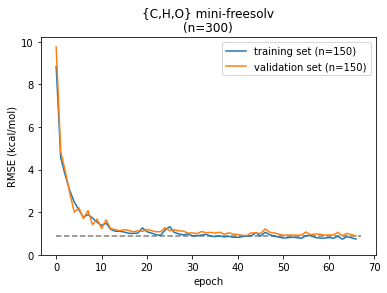

In [147]:
plt.plot(rmses[:,0], label=f'training set (n={len(train_inds)})')
plt.plot(rmses[:,1], label=f'validation set (n={len(valid_inds)})')
plt.legend()
plt.hlines(np.min(rmses[:,1]), 0, len(rmses), linestyles='--', color='grey')
plt.xlabel('epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0,)
plt.title('{C,H,O} mini-freesolv' + f'\n(n={len(cho_freesolv)})')

Text(0.5, 1.0, '{C,H,O} mini-freesolv\n(n=300)')

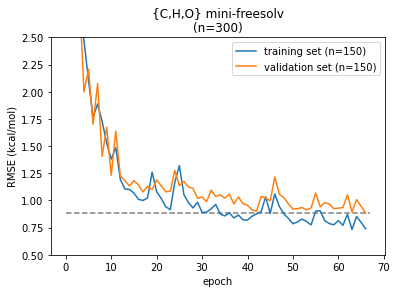

In [150]:
plt.plot(rmses[:,0], label=f'training set (n={len(train_inds)})')
plt.plot(rmses[:,1], label=f'validation set (n={len(valid_inds)})')
plt.legend()
plt.hlines(np.min(rmses[:,1]), 0, len(rmses), linestyles='--', color='grey')
plt.xlabel('epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0.5,2.5)
plt.title('{C,H,O} mini-freesolv' + f'\n(n={len(cho_freesolv)})')

In [138]:
rmse_in_kcalmol = [np.sqrt(b * kT / unit.kilocalories_per_mole) for b in batch_losses]

Text(0.5, 1.0, 'minibatch loss trajectory')

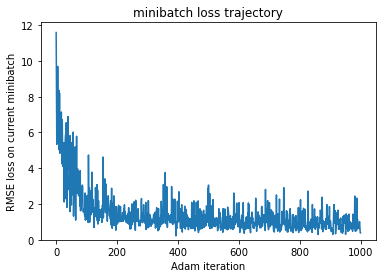

In [139]:
plt.plot(rmse_in_kcalmol)
plt.xlabel('Adam iteration')
plt.ylabel('RMSE loss on current minibatch')
plt.ylim(0,)
plt.title('minibatch loss trajectory')

In [140]:
final_predict_dict = predictions[-1]

In [141]:
float(final_predict_dict[key])

-3.9692380509138947

In [142]:
splits = {
    'training': train_inds,
    'validation': valid_inds,
}

In [151]:
def bootstrap_rmse(sq_residuals, n_bootstrap=1000):
    N = len(sq_residuals)
    
    rmses = [np.sqrt(np.mean(sq_residuals[np.random.randint(0, N, N)])) for _ in range(n_bootstrap)]
    return np.array(rmses)

In [157]:
def report_rmse_pm_95ci(sq_residuals: np.ndarray, n_bootstrap=1000) -> str:
    rmse = np.sqrt(np.mean(sq_residuals))
    rmses = bootstrap_rmse(sq_residuals)
    return f'{rmse:.2f} ' + r'$\pm$' + f' {1.96 * np.std(rmses):.2f}'

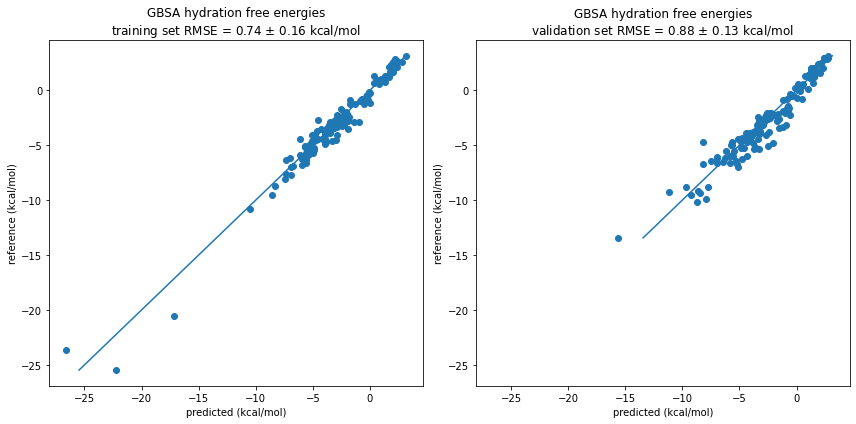

In [159]:
plt.figure(figsize=(12,6))
ax = None

for i, split_name in enumerate(splits):
    split = splits[split_name]
    x = np.array([final_predict_dict[key] for key in split])
    y = np.array([df['experimental value (kcal/mol)'][key] for key in split])
    
    rmse_string = report_rmse_pm_95ci((x - y)**2)
    
    
    ax = plt.subplot(1,2,i+1, sharex=ax, sharey=ax)
    plt.scatter(x, y)
    plt.xlabel('predicted (kcal/mol)')
    plt.ylabel('reference (kcal/mol)')
    plt.plot([min(y), max(y)], [min(y), max(y)])

    plt.title(f'GBSA hydration free energies\n{split_name} set RMSE = {rmse_string} kcal/mol')
plt.tight_layout()

In [160]:
# compare with the RMSE that would be obtained by predicting a constant
np.sqrt(np.mean((y - np.mean(y))**2))

3.1419728381314114

#### TODOs:
* Higher-quality vacuum trajectories
* Add bootstrapped rmse bands to train/validation curves, not just to titles of scatterplots
* Do many train/validation splits and report averages / stddevs
* Currently the input is just element identity, one-hot-encoded --> switch to using espaloma's initial atom featurizer?
* Update loss from un-scaled RMSE to something more like a likelihood (incorporating expt error + free-energy-estimator error)
* Do series of mini-freesolvs